In [6]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from prophet import Prophet

# Import Data

In [32]:
# Import Data
us = pd.read_csv('univariate_datasets/univariate_df_United_States.csv',usecols=[1,2],  parse_dates=[0]).reset_index(drop=True)
us.columns = ['ds', 'y']
belgium = pd.read_csv('univariate_datasets/univariate_df_Belgium.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
belgium.columns = ['ds', 'y']
chile = pd.read_csv('univariate_datasets/univariate_df_Chile.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
chile.columns = ['ds', 'y']
czechia = pd.read_csv('univariate_datasets/univariate_df_Czechia.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
czechia.columns = ['ds', 'y']
estonia = pd.read_csv('univariate_datasets/univariate_df_Estonia.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
estonia.columns = ['ds', 'y']
france = pd.read_csv('univariate_datasets/univariate_df_France.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
france.columns = ['ds', 'y']
ireland = pd.read_csv('univariate_datasets/univariate_df_Ireland.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
ireland.columns = ['ds', 'y']
israel = pd.read_csv('univariate_datasets/univariate_df_Israel.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
israel.columns = ['ds', 'y']
italy = pd.read_csv('univariate_datasets/univariate_df_Italy.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
italy.columns = ['ds', 'y']
malaysia = pd.read_csv('univariate_datasets/univariate_df_Malaysia.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
malaysia.columns = ['ds', 'y']


# test_train split
train_size = int(len(us)*0.8)

small_constant = 1
def mape(y_true, prediction):
    return np.mean(np.abs((y_true - prediction) / (y_true + small_constant))) * 100
mase = MeanAbsoluteScaledError(sp=13)

evaluation = pd.DataFrame(columns = ['Country','Model', 'MAE', 'MAPE'])

# US

16:08:09 - cmdstanpy - INFO - Chain [1] start processing
16:08:09 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_8800/3543773672.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':'United States',
16:08:09 - cmdstanpy - INFO - Chain [1] start processing
16:08:10 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorre

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.67042,0.198496
1,United States,Changepoint,1091.753818,5738.40159,0.198586


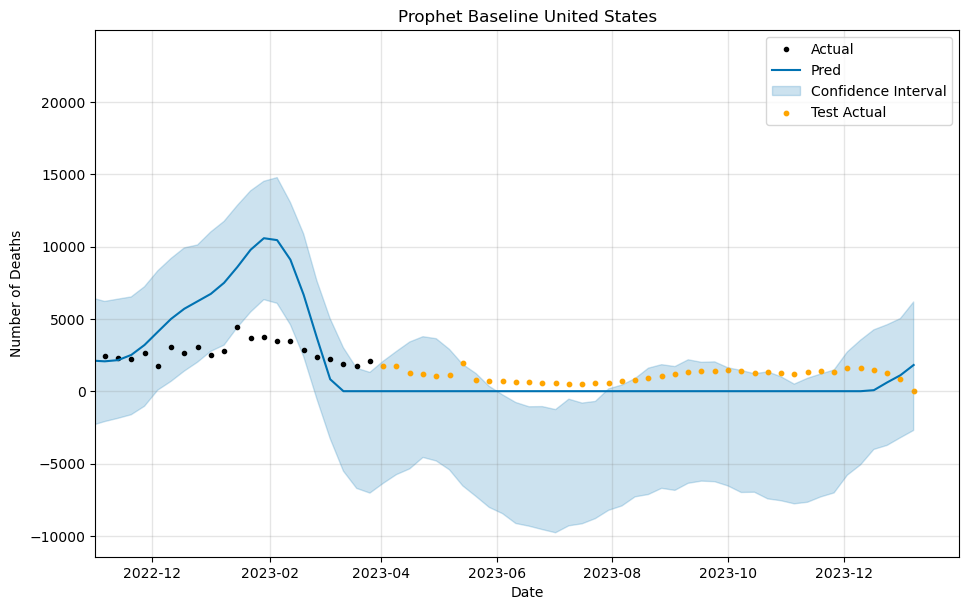

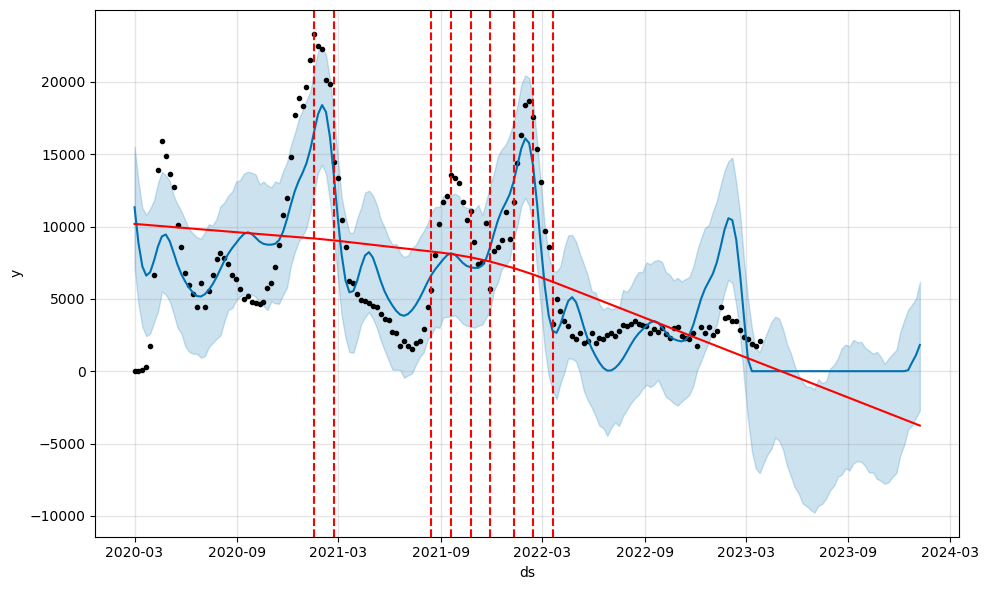

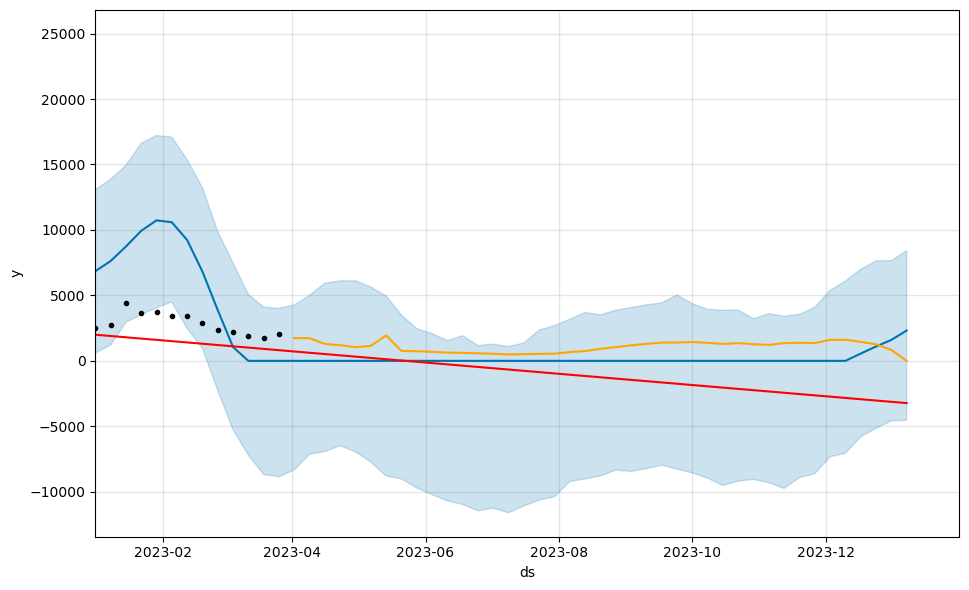

In [33]:
df = us 
train, test = df[0:train_size], df[train_size:]

# baseline prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Baseline United States')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'United States', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points

# Create the prophet model with confidence internal of 95%
model_changepoint = Prophet(interval_width=0.95, n_changepoints=6)
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
fig2 = model_changepoint.plot(forecast_changepoint);
a = add_changepoints_to_plot(fig2.gca(), model_changepoint, forecast_changepoint)
#plot the test data 
plt.plot(test['ds'], test['y'], color = 'orange')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2024-01-31'))
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'United States', 
                                'Model':'Changepoint', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Belgium

22:49:11 - cmdstanpy - INFO - Chain [1] start processing
22:49:11 - cmdstanpy - INFO - Chain [1] done processing


/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_16076/1075204780.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':'Belgium',
22:49:13 - cmdstanpy - INFO - Chain [1] start processing
22:49:13 - cmdstanpy - INFO - Chain [1] done processing
22:49:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:49:13 - cmdstanpy - INFO - Chain [1] start processing
22:49:14 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packa

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.366371
1,United States,Changepoint,1081.527845,13501.162968,0.363103
2,Belgium,Baseline,57.538519,2312.254946,0.325486
3,Belgium,Changepoint,54.841183,2125.325280,0.310228


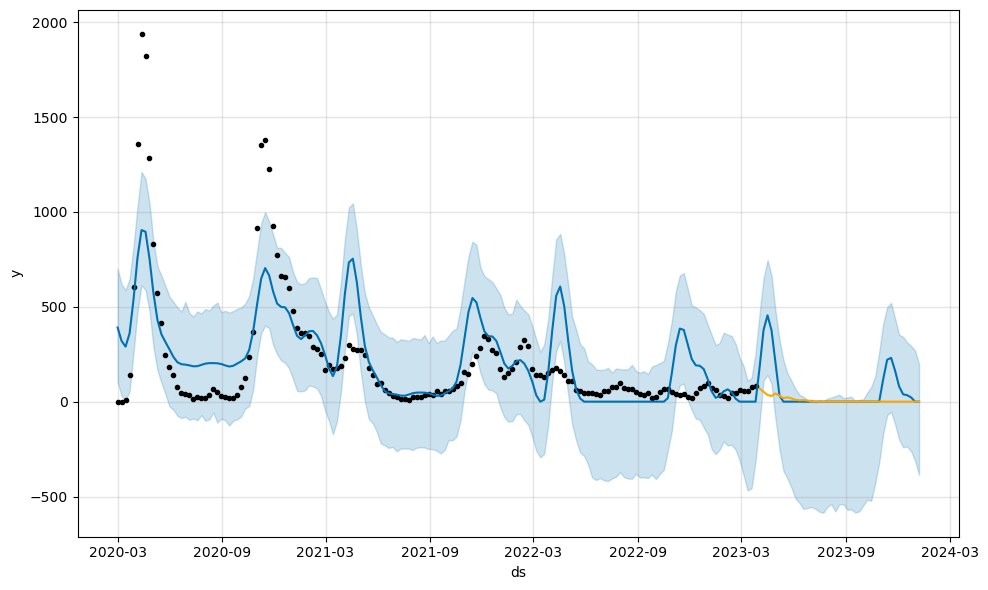

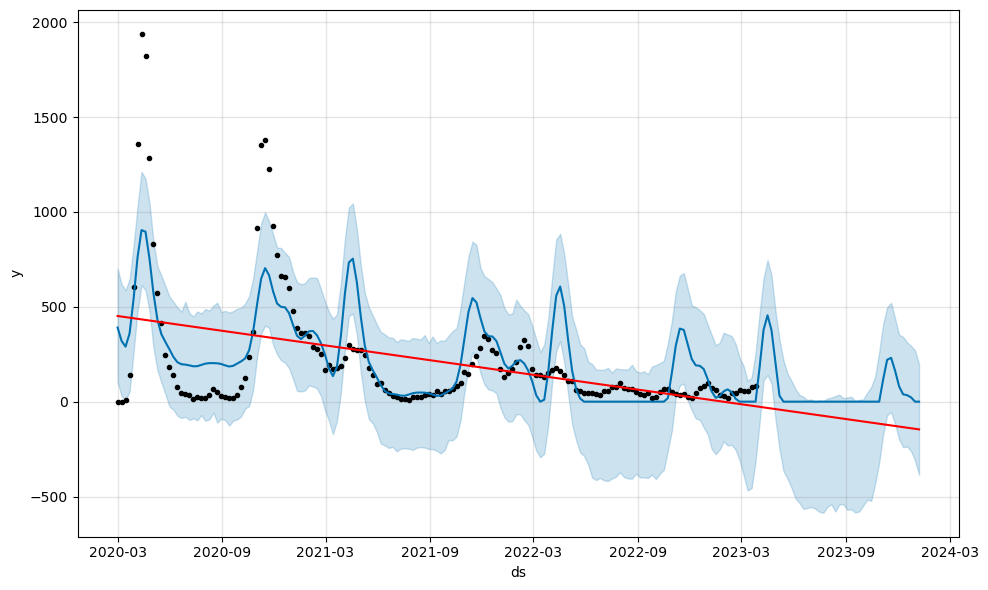

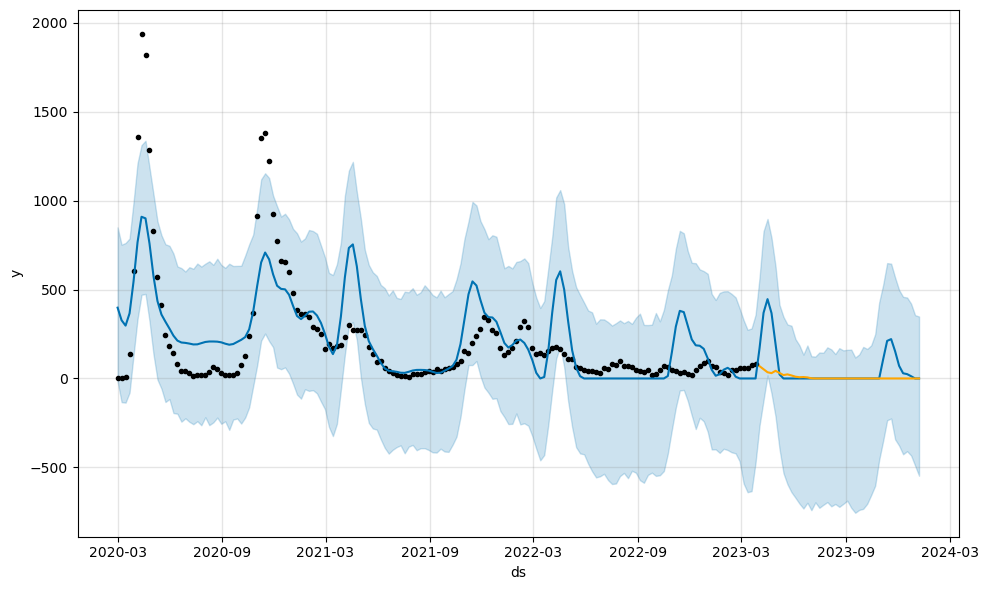

In [120]:
train, test = belgium[0:train_size], belgium[train_size:]

# baseline prophet model
model_baseline = Prophet()
model_baseline.fit(train)
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.plot(test['ds'], test['y'], color = 'orange')
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Belgium', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points

# Create the prophet model with confidence internal of 95%
model_changepoint = Prophet(interval_width=0.95, n_changepoints=0)
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint);
#plot the test data 
plt.plot(test['ds'], test['y'], color = 'orange')
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Belgium', 
                                'Model':'Changepoint', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Chile

22:49:15 - cmdstanpy - INFO - Chain [1] start processing
22:49:15 - cmdstanpy - INFO - Chain [1] done processing


/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_16076/2826021931.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':'Chile',
22:49:15 - cmdstanpy - INFO - Chain [1] start processing
22:49:15 - cmdstanpy - INFO - Chain [1] done processing
22:49:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:49:15 - cmdstanpy - INFO - Chain [1] start processing
22:49:15 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-package

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.366371
1,United States,Changepoint,1081.527845,13501.162968,0.363103
2,Belgium,Baseline,57.538519,2312.254946,0.325486
3,Belgium,Changepoint,54.841183,2125.325280,0.310228
4,Chile,Baseline,214.633967,2422.805759,0.737203
5,Chile,Changepoint,272.290918,3552.308239,0.935237


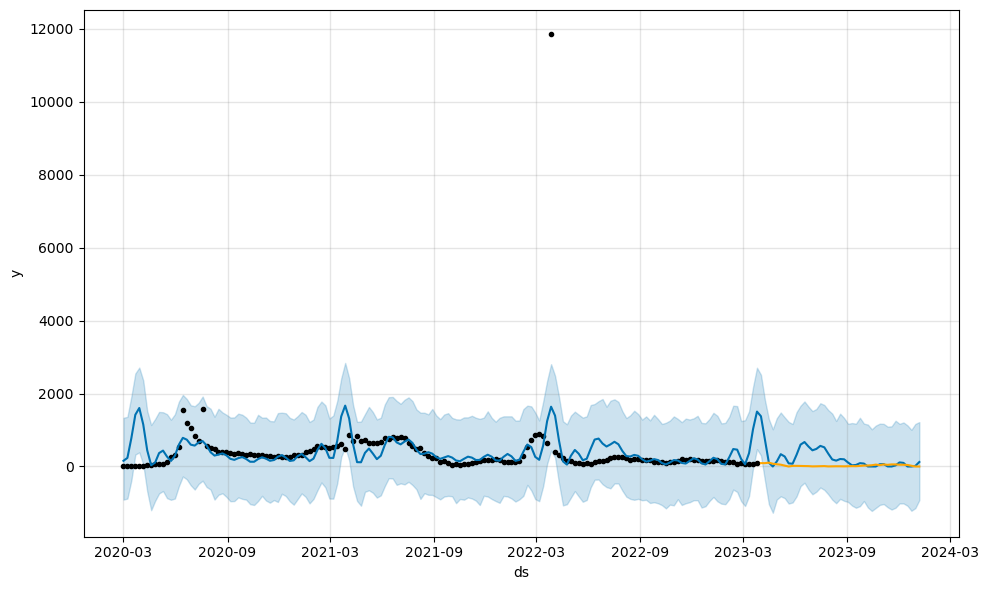

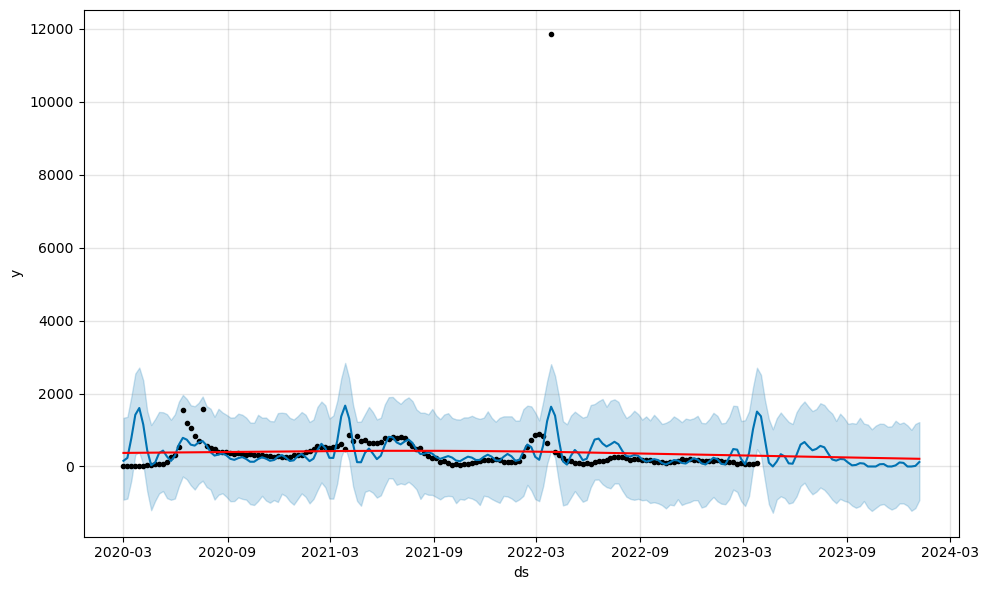

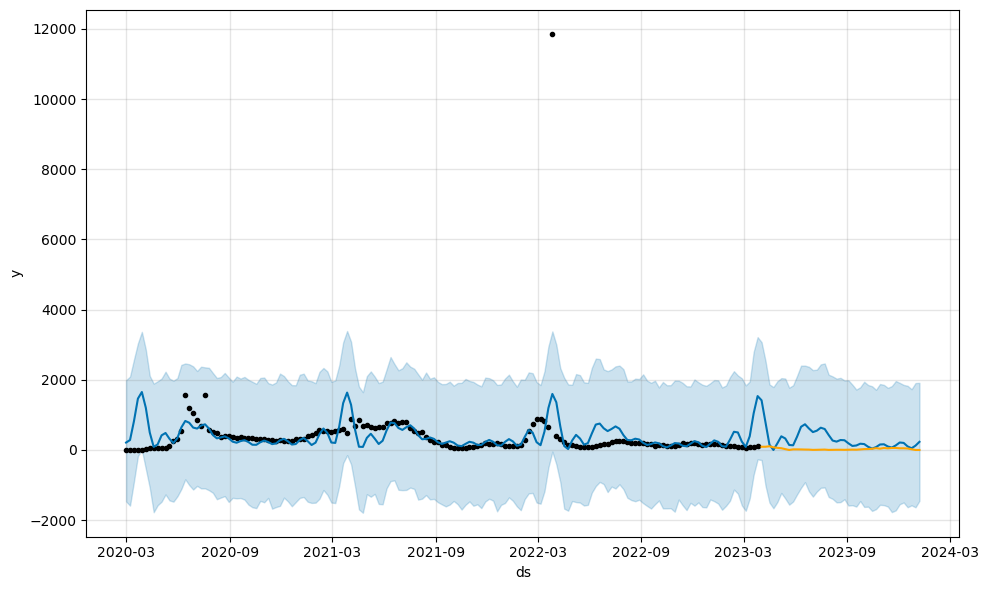

In [121]:
train, test = chile[0:train_size], chile[train_size:]

# baseline prophet model
model_baseline = Prophet()
model_baseline.fit(train)
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.plot(test['ds'], test['y'], color = 'orange')
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Chile', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points

# Create the prophet model with confidence internal of 95%
model_changepoint = Prophet(interval_width=0.95, n_changepoints=0)
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint);
#plot the test data 
plt.plot(test['ds'], test['y'], color = 'orange')
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Chile', 
                                'Model':'Changepoint', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Czechia

22:49:16 - cmdstanpy - INFO - Chain [1] start processing
22:49:16 - cmdstanpy - INFO - Chain [1] done processing


/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_16076/1007459362.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':'Czechia',
22:49:17 - cmdstanpy - INFO - Chain [1] start processing
22:49:17 - cmdstanpy - INFO - Chain [1] done processing
22:49:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:49:17 - cmdstanpy - INFO - Chain [1] start processing
22:49:17 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packa

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.366371
1,United States,Changepoint,1081.527845,13501.162968,0.363103
2,Belgium,Baseline,57.538519,2312.254946,0.325486
3,Belgium,Changepoint,54.841183,2125.325280,0.310228
4,Chile,Baseline,214.633967,2422.805759,0.737203
5,Chile,Changepoint,272.290918,3552.308239,0.935237
6,Czechia,Baseline,28.907951,84.728045,0.174788
7,Czechia,Changepoint,62.993756,963.575661,0.380883


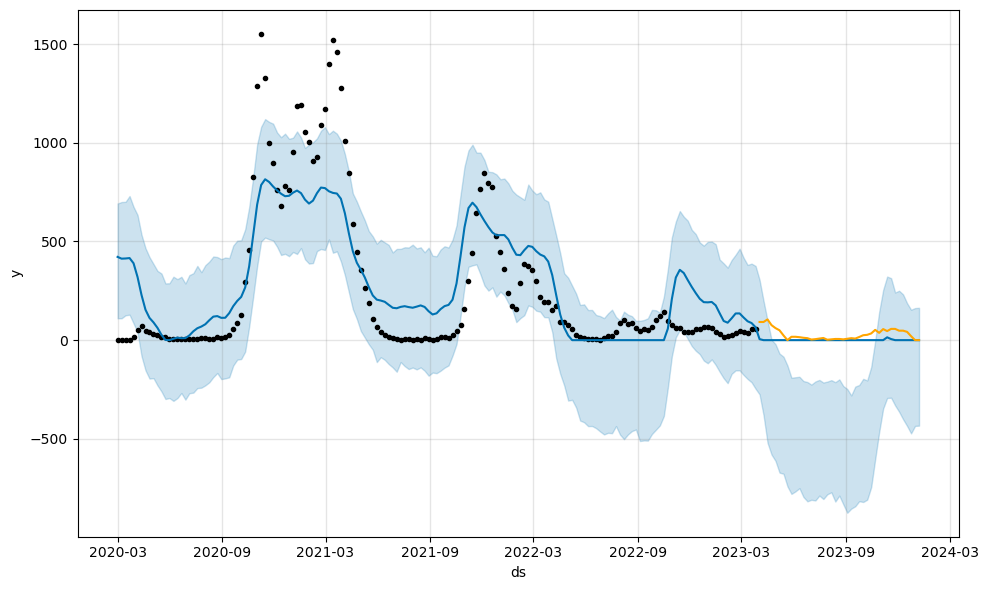

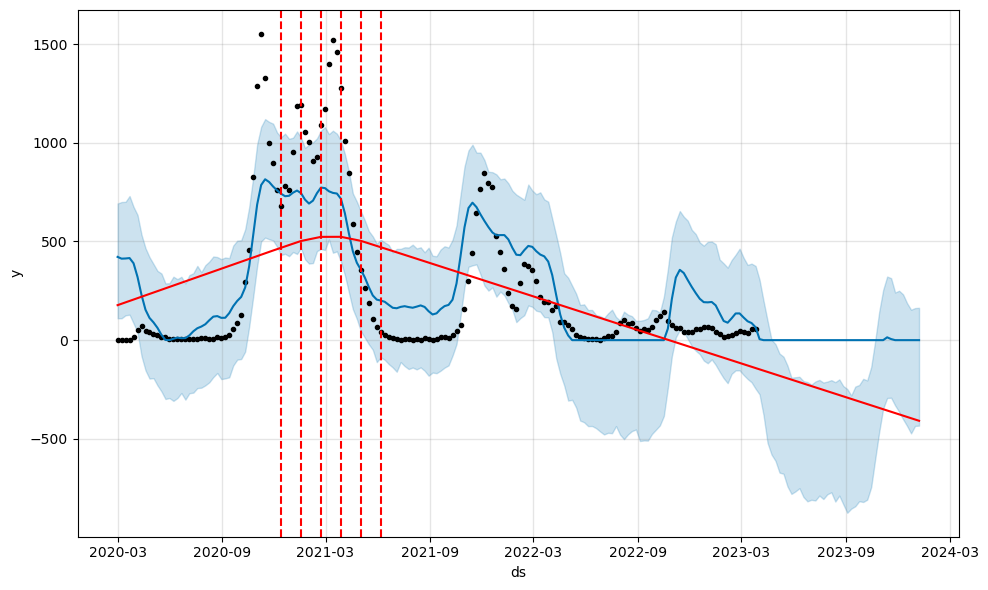

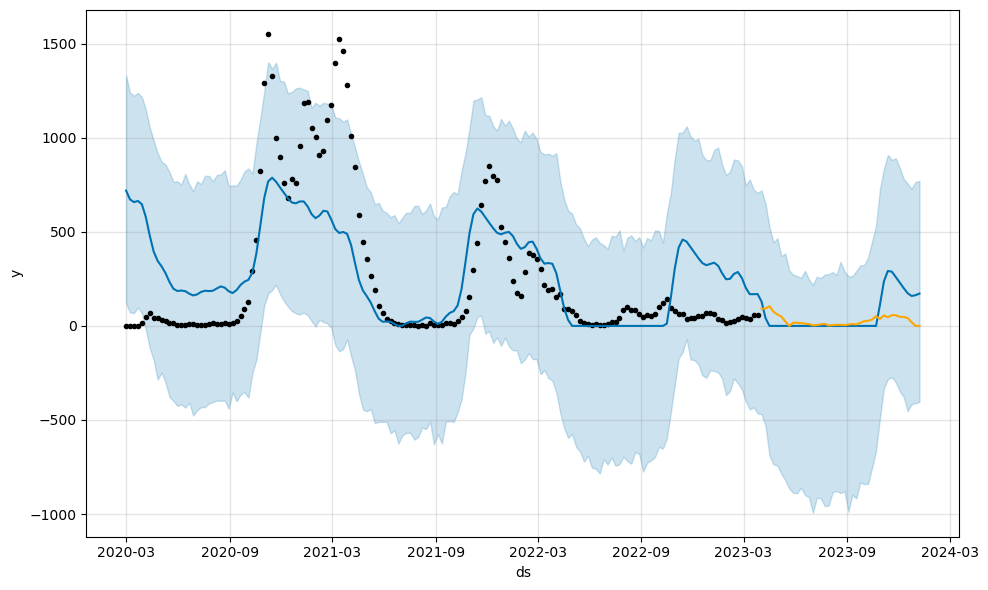

In [122]:
train, test = czechia[0:train_size], chile[train_size:]

# baseline prophet model
model_baseline = Prophet()
model_baseline.fit(train)
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.plot(test['ds'], test['y'], color = 'orange')
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Czechia', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points

# Create the prophet model with confidence internal of 95%
model_changepoint = Prophet(interval_width=0.95, n_changepoints=1)
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint);
#plot the test data 
plt.plot(test['ds'], test['y'], color = 'orange')
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Czechia', 
                                'Model':'Changepoint', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Estonia

22:49:18 - cmdstanpy - INFO - Chain [1] start processing


22:49:18 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_16076/2942767759.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':'Estonia',
22:49:18 - cmdstanpy - INFO - Chain [1] start processing
22:49:18 - cmdstanpy - INFO - Chain [1] done processing
22:49:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:49:18 - cmdstanpy - INFO - Chain [1] start processing
22:49:18 - cmdstanpy - INFO - Chain [1] done processing


,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.366371
1,United States,Changepoint,1081.527845,13501.162968,0.363103
2,Belgium,Baseline,57.538519,2312.254946,0.325486
3,Belgium,Changepoint,54.841183,2125.325280,0.310228
4,Chile,Baseline,214.633967,2422.805759,0.737203
5,Chile,Changepoint,272.290918,3552.308239,0.935237
6,Czechia,Baseline,28.907951,84.728045,0.174788
7,Czechia,Changepoint,62.993756,963.575661,0.380883
8,Estonia,Baseline,3.166873,51.833376,0.263208
9,Estonia,Changepoint,8.768364,432.344534,0.728763


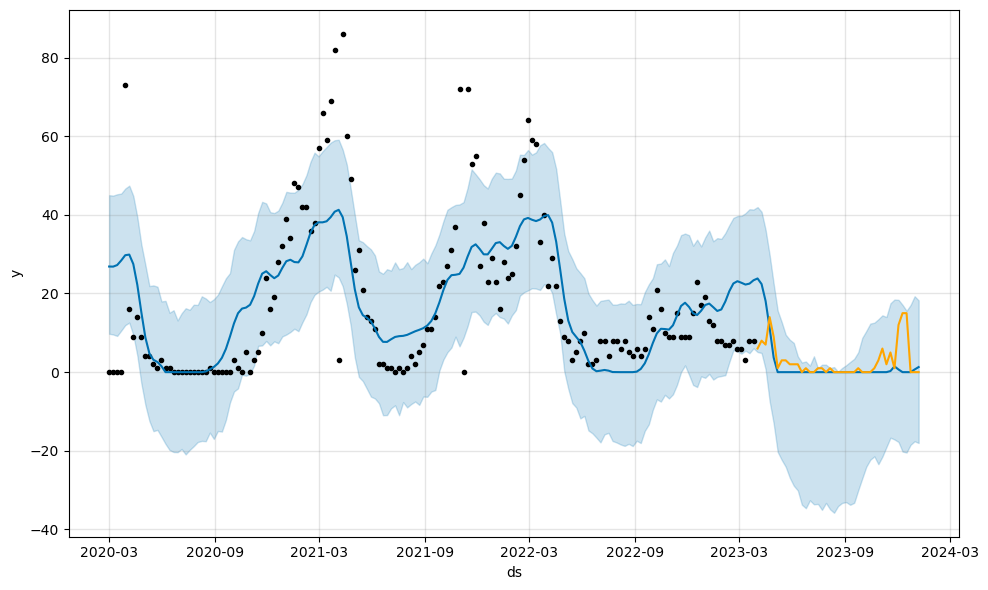

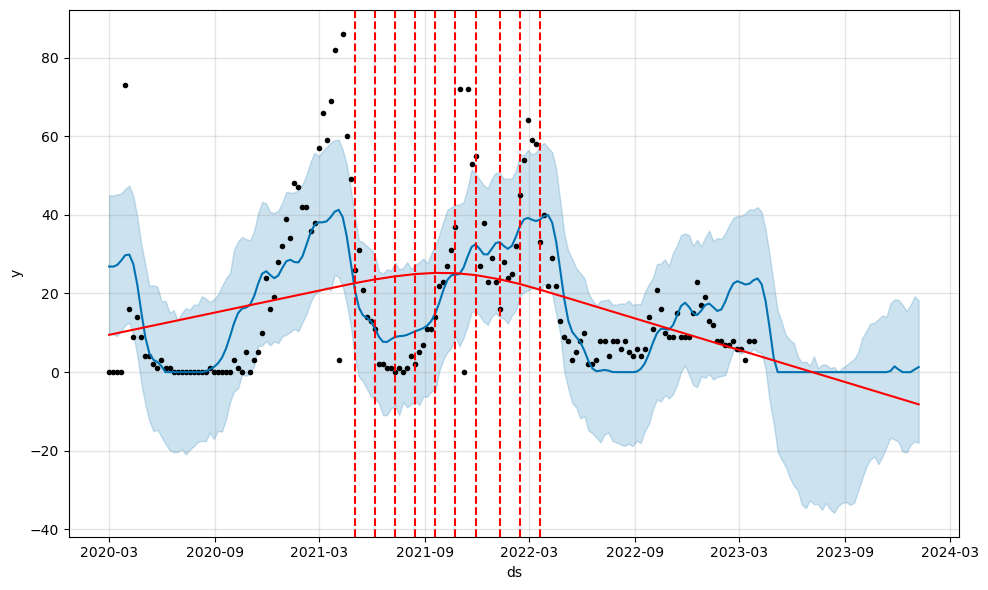

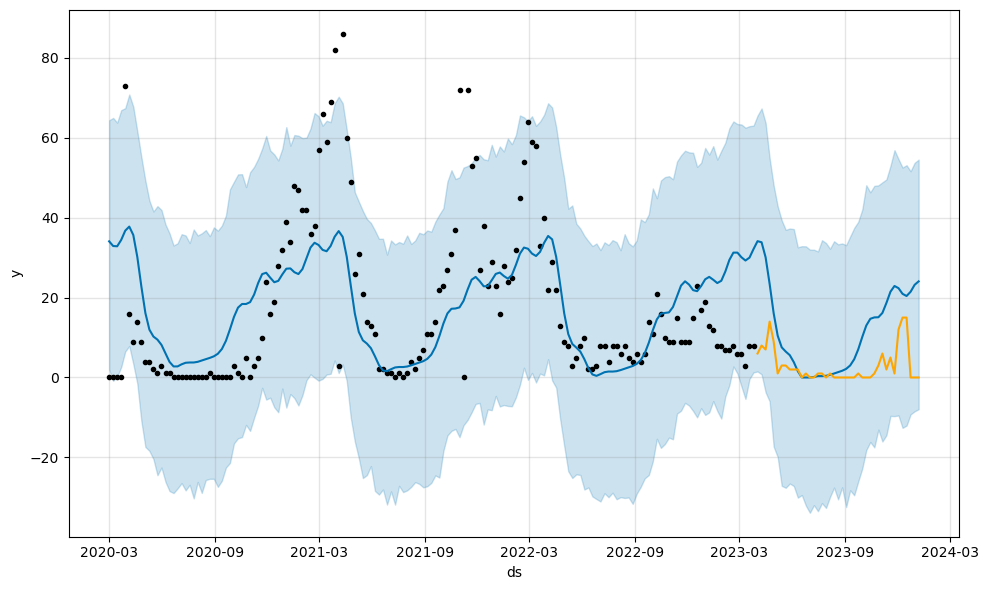

In [123]:
train, test = estonia[0:train_size], estonia[train_size:]

# baseline prophet model
model_baseline = Prophet()
model_baseline.fit(train)
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.plot(test['ds'], test['y'], color = 'orange')
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Estonia', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points

# Create the prophet model with confidence internal of 95%
model_changepoint = Prophet(interval_width=0.95, n_changepoints=1)
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint);
#plot the test data 
plt.plot(test['ds'], test['y'], color = 'orange')
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Estonia', 
                                'Model':'Changepoint', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# France

22:49:19 - cmdstanpy - INFO - Chain [1] start processing
22:49:19 - cmdstanpy - INFO - Chain [1] done processing


/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_16076/4270871135.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':'France',
22:49:20 - cmdstanpy - INFO - Chain [1] start processing
22:49:20 - cmdstanpy - INFO - Chain [1] done processing
22:49:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:49:20 - cmdstanpy - INFO - Chain [1] start processing
22:49:20 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packag

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.366371
1,United States,Changepoint,1081.527845,13501.162968,0.363103
2,Belgium,Baseline,57.538519,2312.254946,0.325486
3,Belgium,Changepoint,54.841183,2125.325280,0.310228
4,Chile,Baseline,214.633967,2422.805759,0.737203
5,Chile,Changepoint,272.290918,3552.308239,0.935237
6,Czechia,Baseline,28.907951,84.728045,0.174788
7,Czechia,Changepoint,62.993756,963.575661,0.380883
8,Estonia,Baseline,3.166873,51.833376,0.263208
9,Estonia,Changepoint,8.768364,432.344534,0.728763


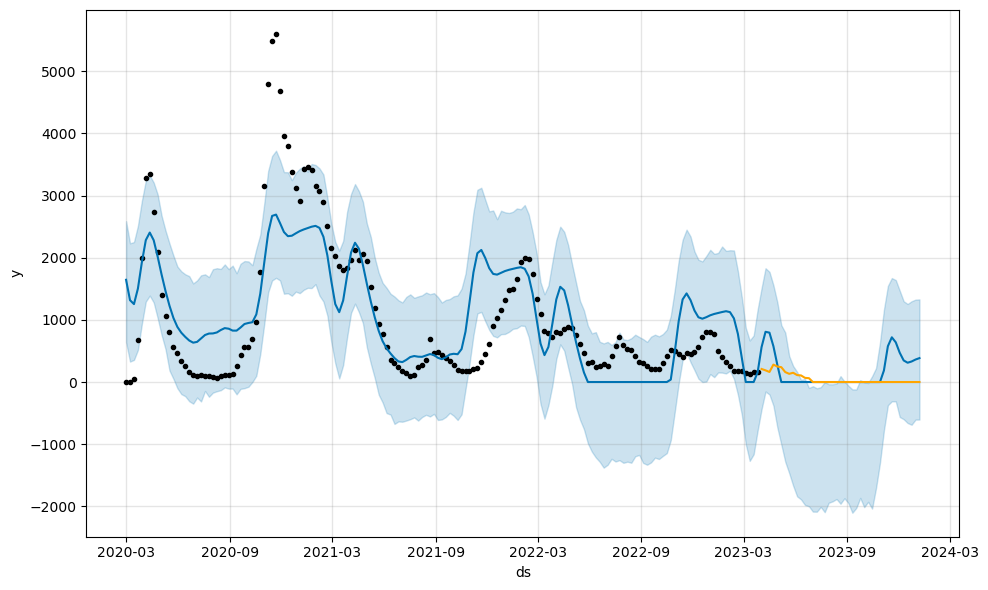

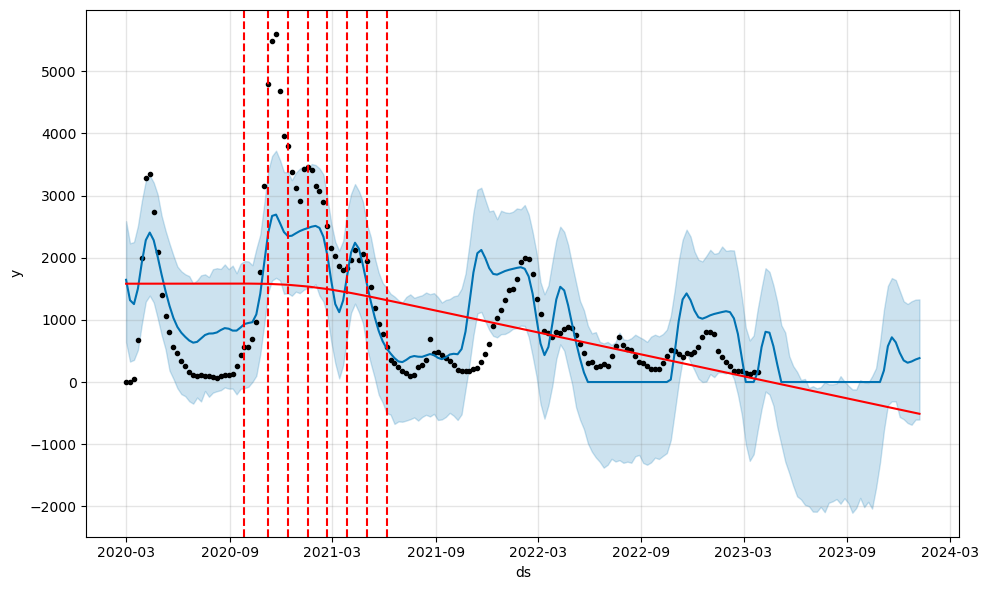

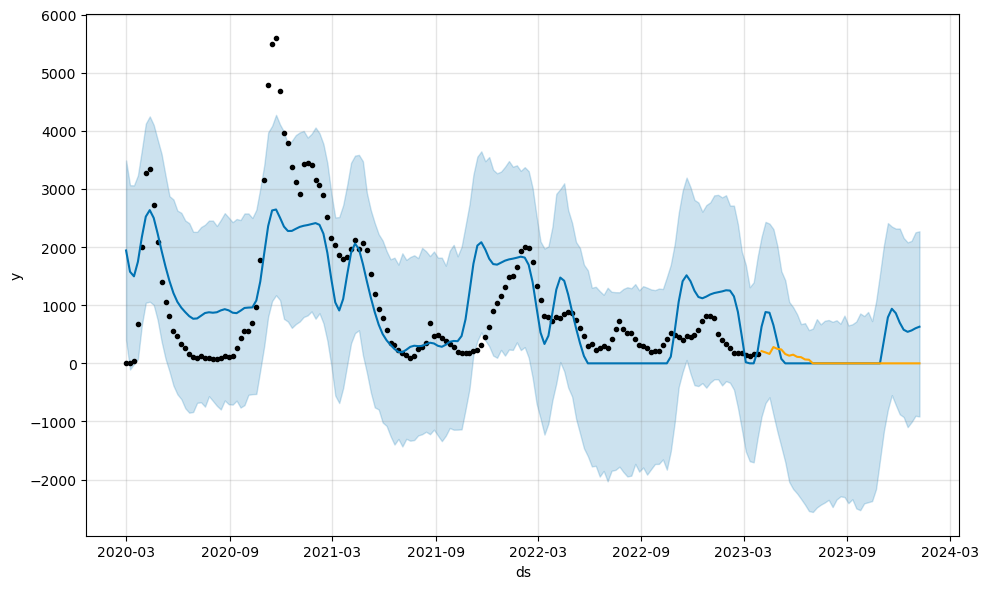

In [124]:
train, test = france[0:train_size], france[train_size:]

# baseline prophet model
model_baseline = Prophet()
model_baseline.fit(train)
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.plot(test['ds'], test['y'], color = 'orange')
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'France', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points

# Create the prophet model with confidence internal of 95%
model_changepoint = Prophet(interval_width=0.95, n_changepoints=1)
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint);
#plot the test data 
plt.plot(test['ds'], test['y'], color = 'orange')
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'France', 
                                'Model':'Changepoint', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Ireland

22:49:21 - cmdstanpy - INFO - Chain [1] start processing
22:49:21 - cmdstanpy - INFO - Chain [1] done processing


/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_16076/3363114160.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':'Ireland',
22:49:21 - cmdstanpy - INFO - Chain [1] start processing
22:49:21 - cmdstanpy - INFO - Chain [1] done processing
22:49:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:49:21 - cmdstanpy - INFO - Chain [1] start processing
22:49:21 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packa

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.366371
1,United States,Changepoint,1081.527845,13501.162968,0.363103
2,Belgium,Baseline,57.538519,2312.254946,0.325486
3,Belgium,Changepoint,54.841183,2125.325280,0.310228
4,Chile,Baseline,214.633967,2422.805759,0.737203
5,Chile,Changepoint,272.290918,3552.308239,0.935237
6,Czechia,Baseline,28.907951,84.728045,0.174788
7,Czechia,Changepoint,62.993756,963.575661,0.380883
8,Estonia,Baseline,3.166873,51.833376,0.263208
9,Estonia,Changepoint,8.768364,432.344534,0.728763


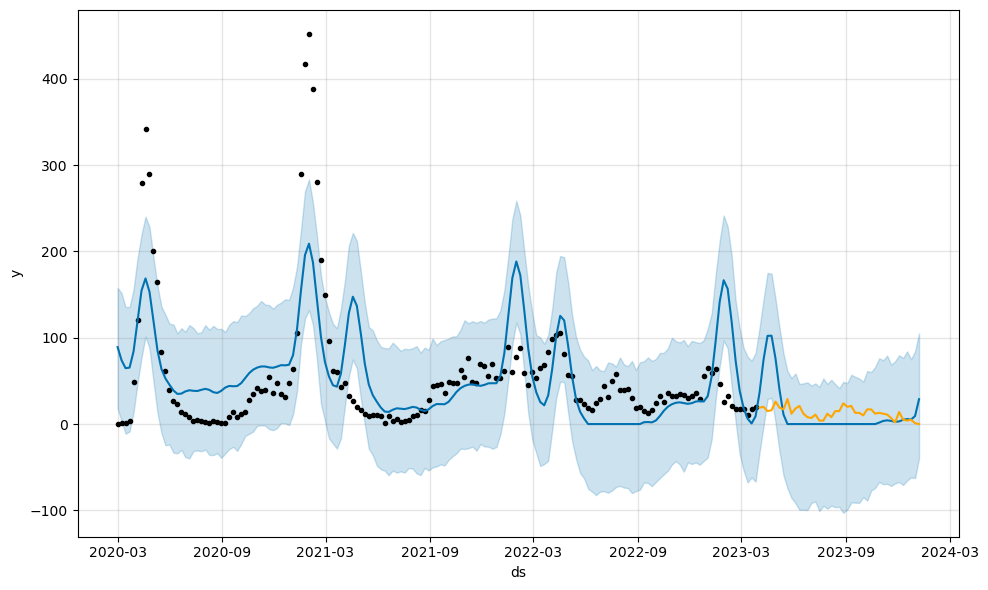

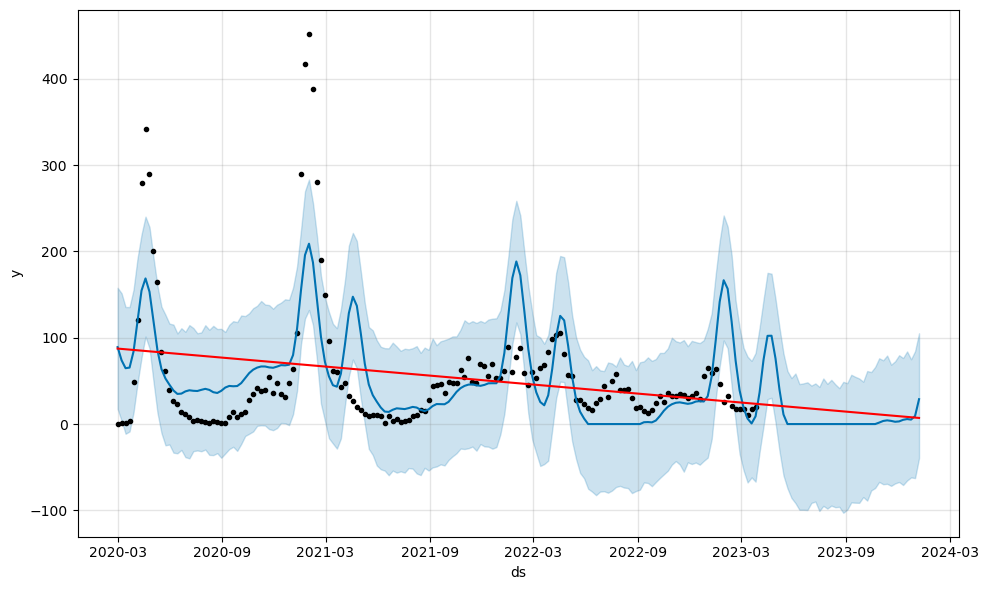

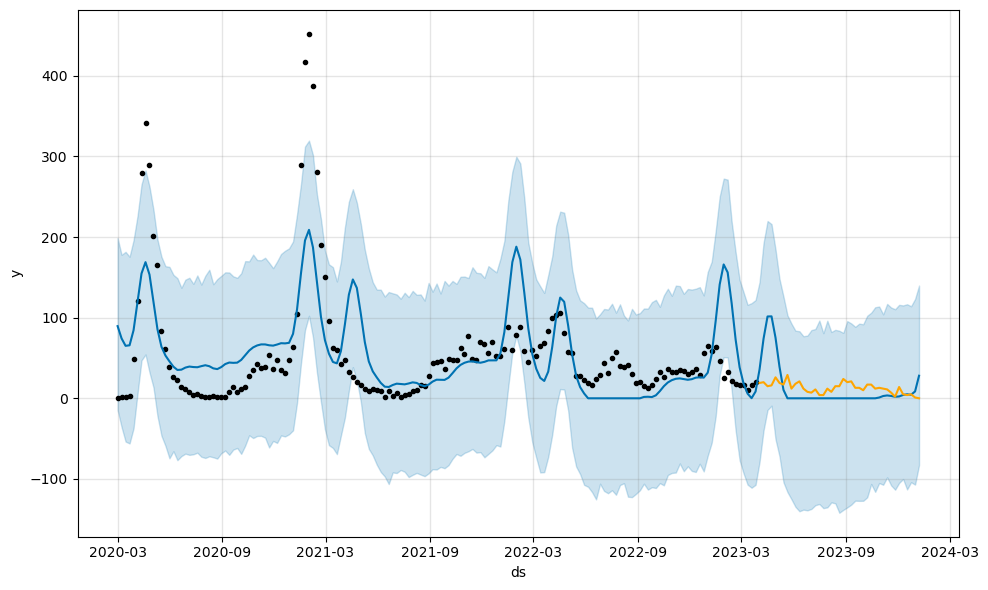

In [125]:
train, test = ireland[0:train_size], ireland[train_size:]

# baseline prophet model
model_baseline = Prophet()
model_baseline.fit(train)
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.plot(test['ds'], test['y'], color = 'orange')
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Ireland', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points

# Create the prophet model with confidence internal of 95%
model_changepoint = Prophet(interval_width=0.95, n_changepoints=0)
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint);
#plot the test data 
plt.plot(test['ds'], test['y'], color = 'orange')
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Ireland', 
                                'Model':'Changepoint', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Israel

15:18:23 - cmdstanpy - INFO - Chain [1] start processing
15:18:23 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_40570/3923305089.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':'Israel',
15:18:24 - cmdstanpy - INFO - Chain [1] start processing
15:18:24 - cmdstanpy - INFO - Chain [1] done processing
15:18:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:18:24 - cmdstanpy - INFO - Chain [1] start processing


,Country,Model,MAE,MAPE,MASE
0,Israel,Baseline,7.847656,140.738918,0.126927
1,Israel,Changepoint,15.251034,403.502932,0.246669
2,Israel,Baseline,7.847656,140.738918,0.126927
3,Israel,Changepoint,15.251034,403.502932,0.246669
4,Israel,Baseline,7.847656,140.738918,0.126927
5,Israel,Changepoint,15.251034,403.502932,0.246669
6,Israel,Baseline,7.847656,140.738918,0.126927
7,Israel,Changepoint,15.251034,403.502932,0.246669
8,Israel,Baseline,7.847656,140.738918,0.126927
9,Israel,Changepoint,15.251034,403.502932,0.246669


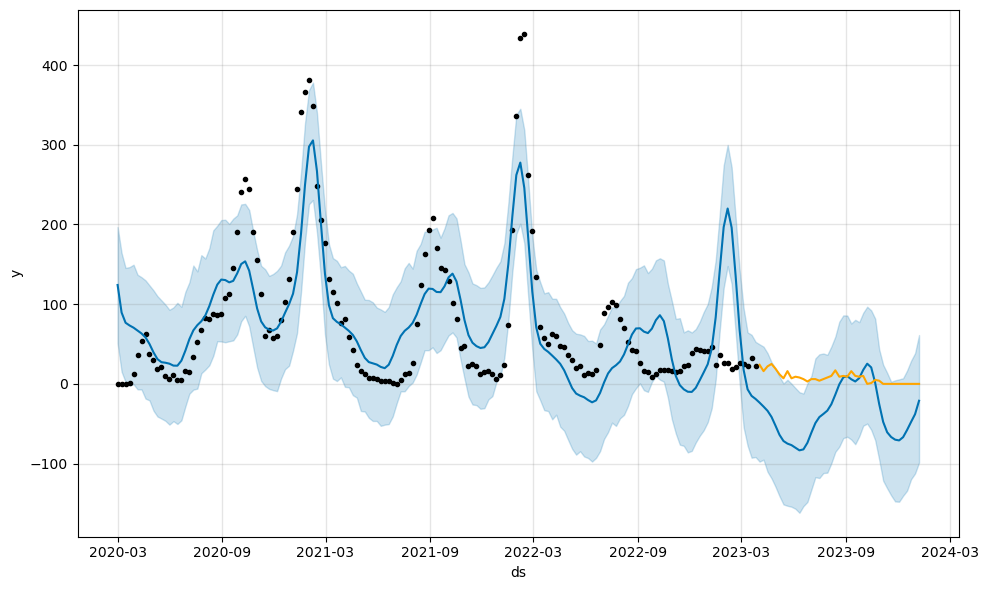

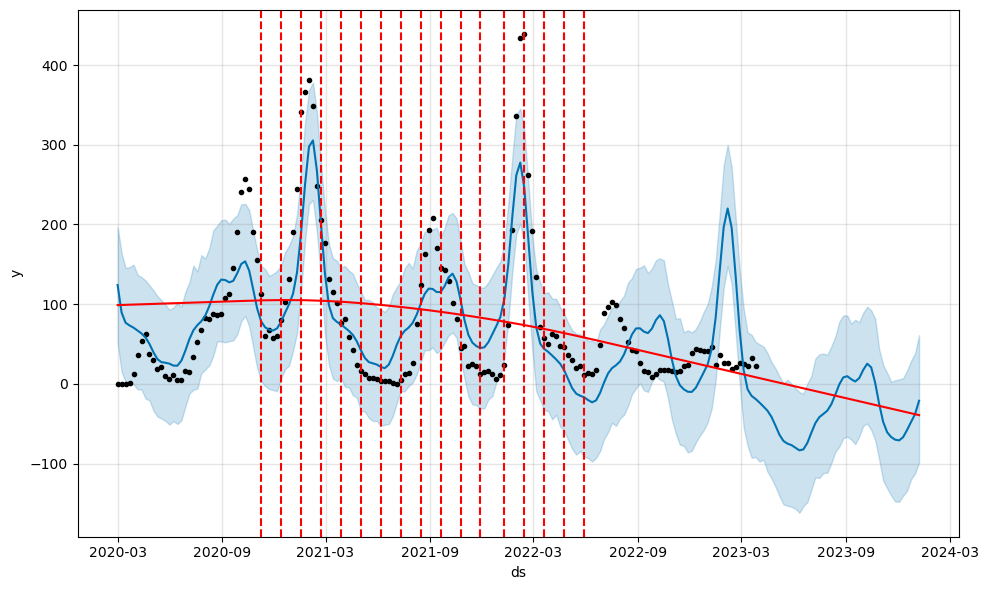

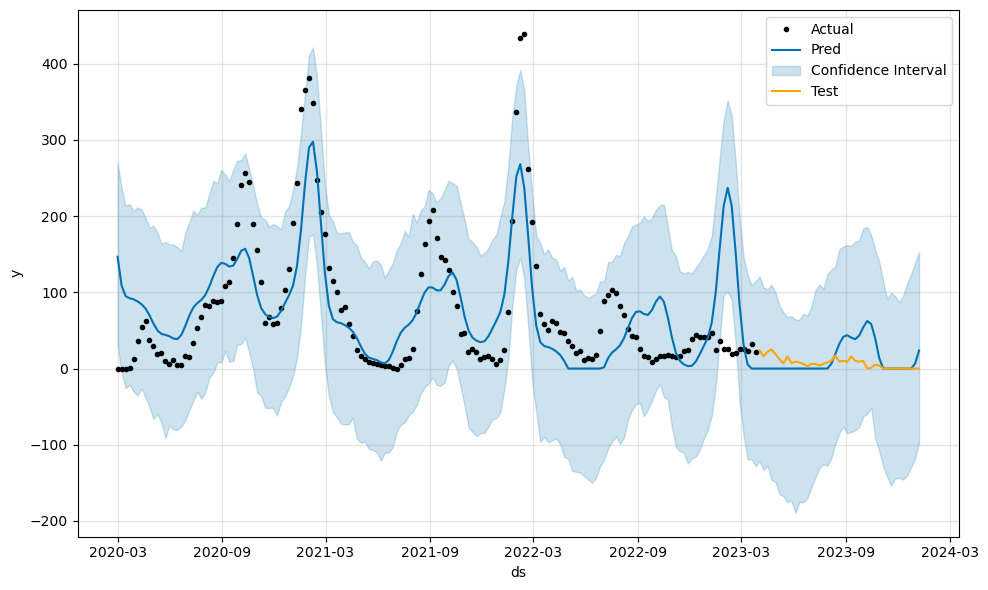

In [11]:
train, test = israel[0:train_size], israel[train_size:]

# baseline prophet model
model_baseline = Prophet()
model_baseline.fit(train)
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.plot(test['ds'], test['y'], color = 'orange')
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Israel', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points

# Create the prophet model with confidence internal of 95%
model_changepoint = Prophet(interval_width=0.95, n_changepoints=1)
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint);
#plot the test data 
plt.plot(test['ds'], test['y'], color = 'orange', label = 'Test');
# add legend to plot 
plt.legend(['Actual', 'Pred','Confidence Interval','Test'])

# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Israel', 
                                'Model':'Changepoint', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Italy

22:49:24 - cmdstanpy - INFO - Chain [1] start processing
22:49:24 - cmdstanpy - INFO - Chain [1] done processing


/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_16076/2869208138.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':'Italy',
22:49:25 - cmdstanpy - INFO - Chain [1] start processing
22:49:25 - cmdstanpy - INFO - Chain [1] done processing
22:49:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:49:25 - cmdstanpy - INFO - Chain [1] start processing
22:49:25 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-package

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.366371
1,United States,Changepoint,1081.527845,13501.162968,0.363103
2,Belgium,Baseline,57.538519,2312.254946,0.325486
3,Belgium,Changepoint,54.841183,2125.325280,0.310228
4,Chile,Baseline,214.633967,2422.805759,0.737203
5,Chile,Changepoint,272.290918,3552.308239,0.935237
6,Czechia,Baseline,28.907951,84.728045,0.174788
7,Czechia,Changepoint,62.993756,963.575661,0.380883
8,Estonia,Baseline,3.166873,51.833376,0.263208
9,Estonia,Changepoint,8.768364,432.344534,0.728763


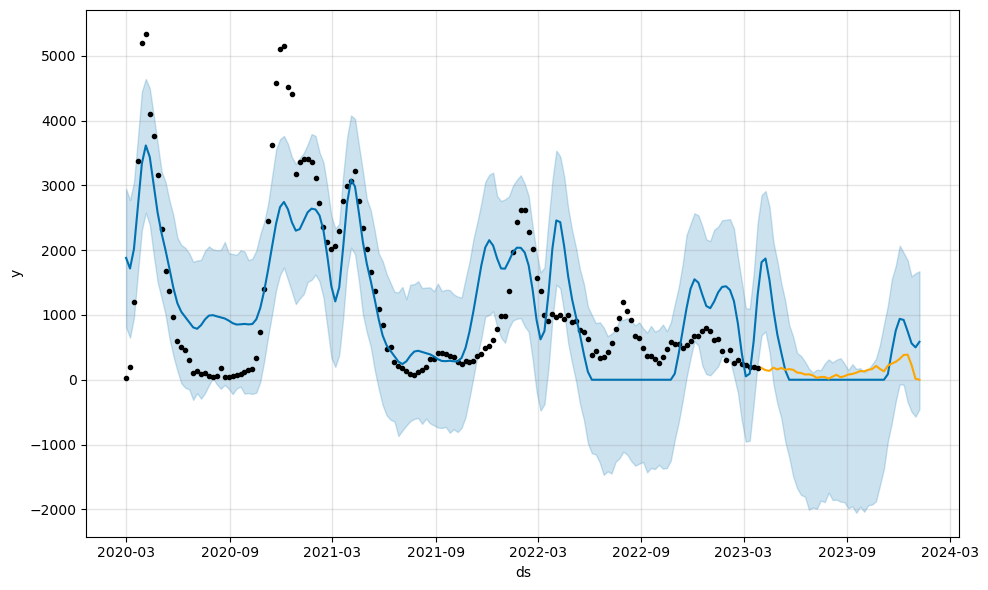

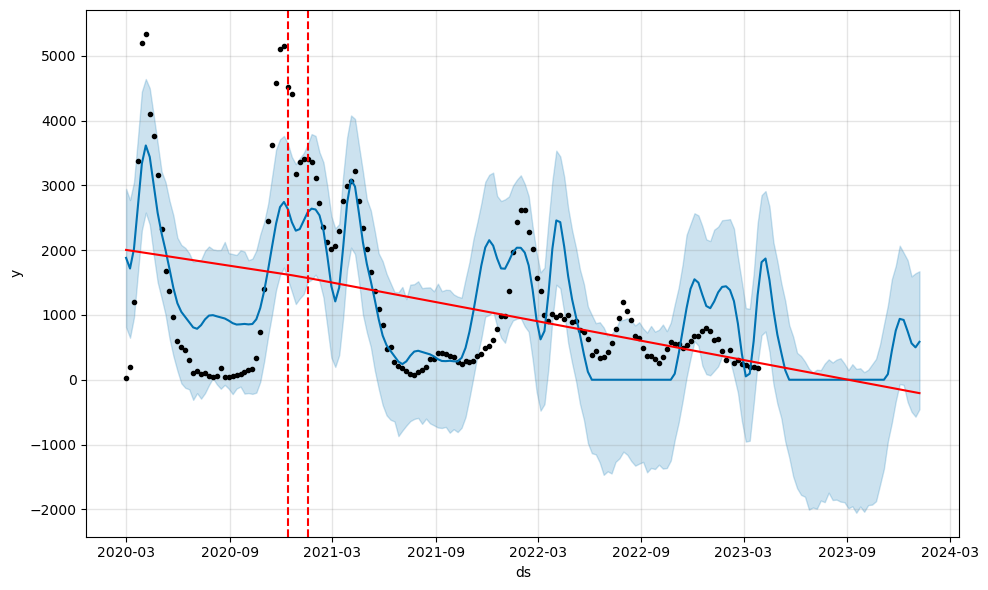

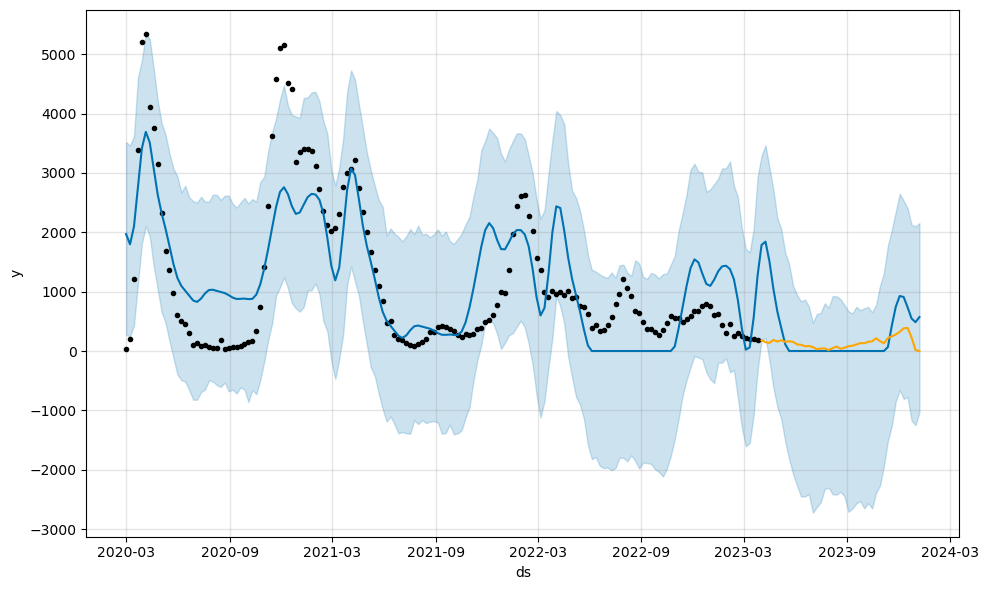

In [127]:
train, test = italy[0:train_size], italy[train_size:]

# baseline prophet model
model_baseline = Prophet()
model_baseline.fit(train)
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.plot(test['ds'], test['y'], color = 'orange')
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Italy', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points

# Create the prophet model with confidence internal of 95%
model_changepoint = Prophet(interval_width=0.95, n_changepoints=0)
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint);
#plot the test data 
plt.plot(test['ds'], test['y'], color = 'orange')
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Italy', 
                                'Model':'Changepoint', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Malaysia 

22:49:26 - cmdstanpy - INFO - Chain [1] start processing
22:49:26 - cmdstanpy - INFO - Chain [1] done processing


/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_16076/2305130621.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':'Malaysia',
22:49:26 - cmdstanpy - INFO - Chain [1] start processing
22:49:26 - cmdstanpy - INFO - Chain [1] done processing
22:49:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:49:26 - cmdstanpy - INFO - Chain [1] start processing
22:49:26 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-pack

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.366371
1,United States,Changepoint,1081.527845,13501.162968,0.363103
2,Belgium,Baseline,57.538519,2312.254946,0.325486
3,Belgium,Changepoint,54.841183,2125.325280,0.310228
4,Chile,Baseline,214.633967,2422.805759,0.737203
5,Chile,Changepoint,272.290918,3552.308239,0.935237
6,Czechia,Baseline,28.907951,84.728045,0.174788
7,Czechia,Changepoint,62.993756,963.575661,0.380883
8,Estonia,Baseline,3.166873,51.833376,0.263208
9,Estonia,Changepoint,8.768364,432.344534,0.728763


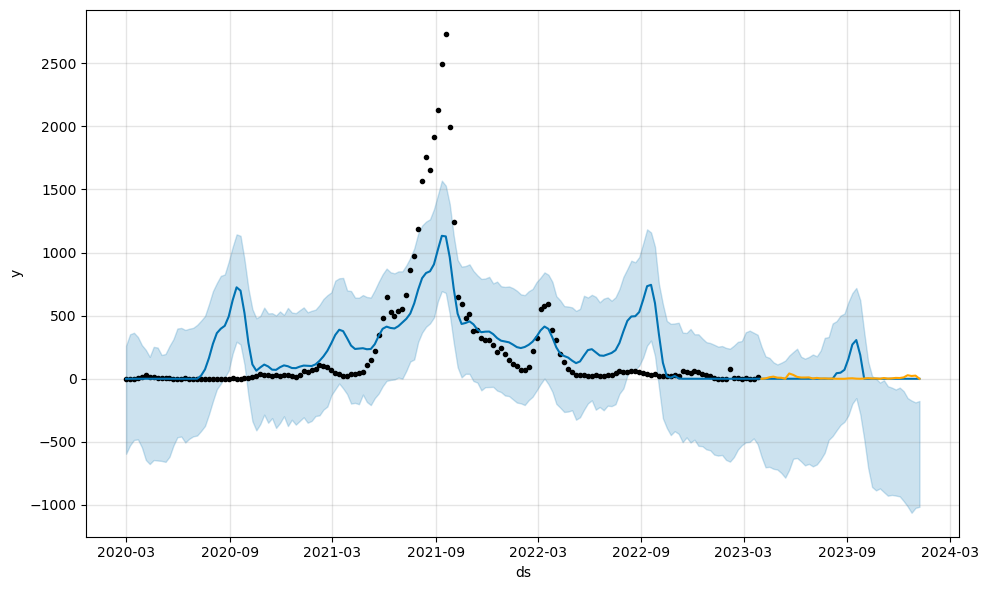

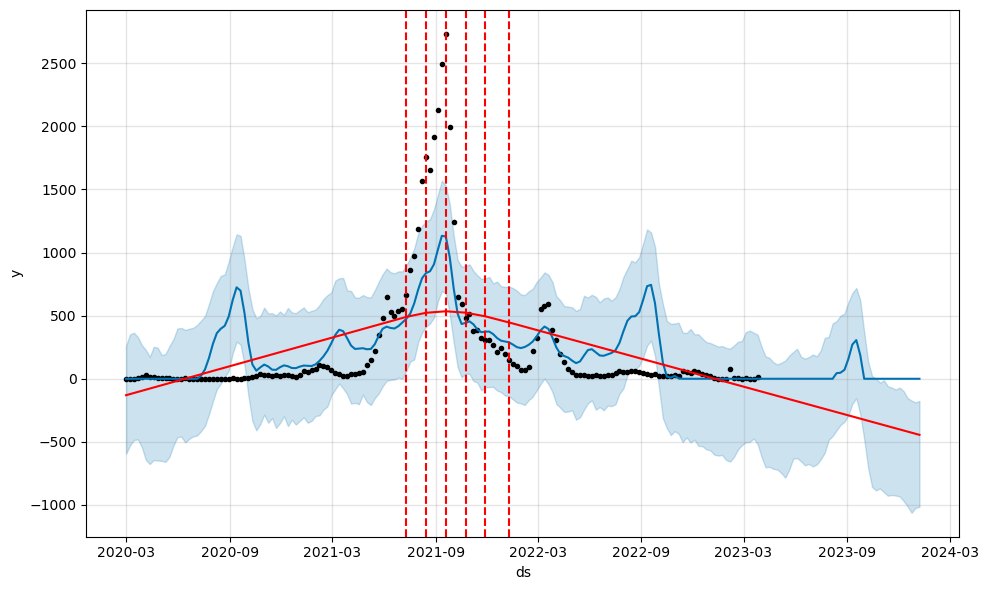

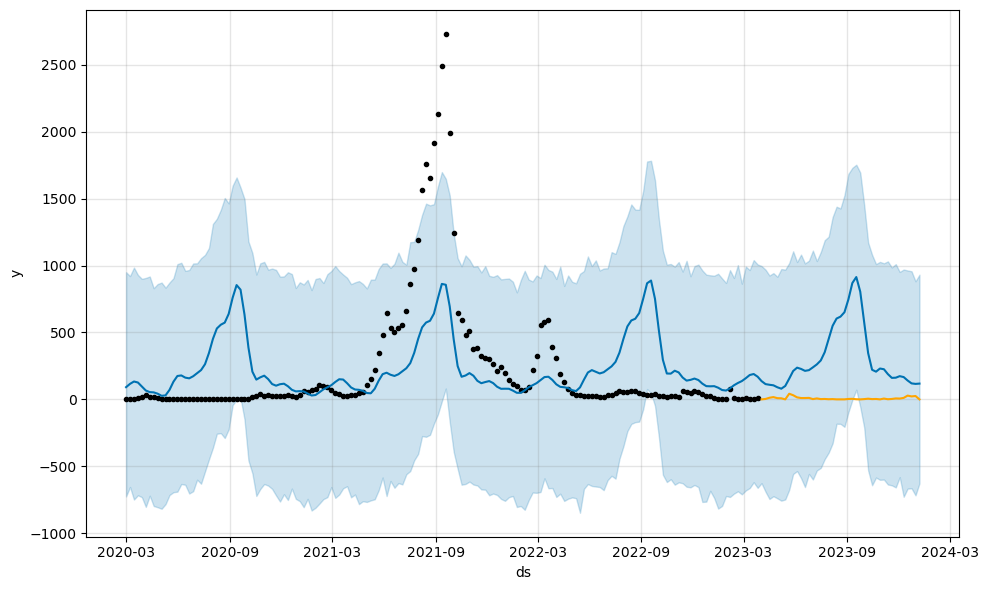

In [128]:
train, test = malaysia[0:train_size], malaysia[train_size:]

# baseline prophet model
model_baseline = Prophet()
model_baseline.fit(train)
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.plot(test['ds'], test['y'], color = 'orange')
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Malaysia', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points

# Create the prophet model with confidence internal of 95%
model_changepoint = Prophet(interval_width=0.95, n_changepoints=1)
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint);
#plot the test data 
plt.plot(test['ds'], test['y'], color = 'orange')
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'Malaysia', 
                                'Model':'Changepoint', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation